In [1]:
import numpy as np
from matplotlib import pyplot as plt
import uproot
import torch

In [2]:
import torch 
import torch.nn as nn
from fast_soft_sort.pytorch_ops import soft_rank
import torch.nn.functional as F
import torch.distributed as dist

class CorrLoss(nn.Module):
    def __init__(self, corr=False,ipow=1,sort_tolerance=1.0,sort_reg='l2'):
        super(CorrLoss, self).__init__()
        self.tolerance = sort_tolerance
        self.reg       = sort_reg
        self.corr      = corr
        self.ipow      = ipow
        
    def spearman(self, pred, target):
        pred   = soft_rank(pred.reshape(1,-1),regularization=self.reg,regularization_strength=self.tolerance,)
        target = soft_rank(target.reshape(1,-1),regularization=self.reg,regularization_strength=self.tolerance,)
        #pred   = torchsort.soft_rank(pred.reshape(1,-1),regularization_strength=x)
        #target = torchsort.soft_rank(target.reshape(1,-1),regularization_strength=x)
        pred = pred - pred.mean()
        pred =   10*(pred / pred.norm())
        target = target - target.mean()
        target = 10*(target / target.norm())
        pred   = pred.pow(self.ipow)
        target = target.pow(self.ipow)
        ret = ((pred * target)).sum()
        if self.corr:
            return (1-ret)*(1-ret)
        else:
            return ret*ret
    
    def forward(self, features, labels,mask=None):
        if mask is not None:
            featuretest=features[mask]
            labeltest=labels[mask]
        else:
            featuretest=features
            labeltest=labels
        return self.spearman(featuretest,labeltest) 

class CorrLoss2(nn.Module):
    def __init__(self,background_only=False,background_label=1,power=2):
        self.backonly = background_only
        self.background_label = background_label
        self.power = power

    def distance_corr(self,var_1,var_2,normedweight,power=1):
        #xx = var_1.view(-1, 1).expand(len(var_1), len(var_1)).view(len(var_1),len(var_1))
        #yy = var_1.expand(len(var_1),len(var_1)).view(len(var_1),len(var_1))
        #amat = (xx-yy).abs()

        xx = var_1.view(-1, 1).expand(len(var_1), len(var_1)).view(len(var_1),len(var_1))
        yy = var_1.            expand(len(var_1),len(var_1)).view(len(var_1),len(var_1))
        amat = (xx-yy).abs()
        print(amat)
        del xx,yy
        amatavg = torch.mean(amat*normedweight,dim=1)
        Amat=amat-amatavg.expand(len(var_1),len(var_1)).view(len(var_1),len(var_1))\
            -amatavg.view(-1, 1).expand(len(var_1), len(var_1)).view(len(var_1),len(var_1))\
            +torch.mean(amatavg*normedweight)
        del amat
        
        xx = var_2.view(-1, 1).expand(len(var_2), len(var_2)).view(len(var_2),len(var_2))
        #yy = var_2.expand(len(var_2),len(var_2)).view(len(var_2),len(var_2))
        bmat = (xx).abs()
        del xx

        bmatavg = torch.mean(bmat*normedweight,dim=1)
        Bmat=bmat-bmatavg.expand(len(var_2),len(var_2)).view(len(var_2),len(var_2))\
            -bmatavg.view(-1, 1).expand(len(var_2), len(var_2)).view(len(var_2),len(var_2))\
            +torch.mean(bmatavg*normedweight)
        del bmat

        ABavg = torch.mean(Amat*Bmat*normedweight,dim=1)
        AAavg = torch.mean(Amat*Amat*normedweight,dim=1)
        BBavg = torch.mean(Bmat*Bmat*normedweight,dim=1)
        del Bmat, Amat

        if(power==1):
            dCorr=(torch.mean(ABavg*normedweight))/torch.sqrt((torch.mean(AAavg*normedweight)*torch.mean(BBavg*normedweight)))
        elif(power==2):
            dCorr=(torch.mean(ABavg*normedweight))**2/(torch.mean(AAavg*normedweight)*torch.mean(BBavg*normedweight))
        else:
            dCorr=((torch.mean(ABavg*normedweight))/torch.sqrt((torch.mean(AAavg*normedweight)*torch.mean(BBavg*normedweight))))**power

        return dCorr

    def __call__(self,pred,x_biased,weights=None):
        xweights = torch.ones_like(pred)
        disco = self.distance_corr(x_biased,pred,normedweight=xweights,power=self.power)
        return disco


    
#finally lets check it all
def compute_ROC(labels, predicts, npts=10001):
    lMin = np.min(predicts)
    lMax = np.max(predicts)
    cutvals = np.linspace(lMin,lMax,num=npts)
    tot0 = float(len(labels[labels==0]))
    tot1 = float(len(labels[labels==1]))
    tpr = []
    fpr = []
    for c in cutvals:
        fpr.append(float(len(predicts[(labels==0) & (predicts>c)]))/tot0)
        tpr.append(float(len(predicts[(labels==1) & (predicts>c)]))/tot1)
    return np.array(fpr),np.array(tpr)

class SupConLoss(nn.Module):
    """Supervised Contrastive Learning: https://arxiv.org/pdf/2004.11362.pdf.
    It also supports the unsupervised contrastive loss in SimCLR"""
    def __init__(self, temperature=0.07, contrast_mode='all',
                 base_temperature=0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature
        self.contrast_mode = contrast_mode
        self.base_temperature = base_temperature

    def forward(self, features, labels=None, mask=None):
        """Compute loss for model. If both `labels` and `mask` are None,
        it degenerates to SimCLR unsupervised loss:
        https://arxiv.org/pdf/2002.05709.pdf
        Args:
            features: hidden vector of shape [bsz, n_views, ...].
            labels: ground truth of shape [bsz].
            mask: contrastive mask of shape [bsz, bsz], mask_{i,j}=1 if sample j
                has the same class as sample i. Can be asymmetric.
        Returns:
            A loss scalar.
        """
        device = (torch.device('cuda')
                  if features.is_cuda
                  else torch.device('cpu'))

        if len(features.shape) < 3:
            raise ValueError('`features` needs to be [bsz, n_views, ...],'
                             'at least 3 dimensions are required')
        if len(features.shape) > 3:
            features = features.view(features.shape[0], features.shape[1], -1)

        batch_size = features.shape[0]
        if labels is not None and mask is not None:
            raise ValueError('Cannot define both `labels` and `mask`')
        elif labels is None and mask is None:
            mask = torch.eye(batch_size, dtype=torch.float32).to(device)
        elif labels is not None:
            labels = labels.contiguous().view(-1, 1)
            if labels.shape[0] != batch_size:
                raise ValueError('Num of labels does not match num of features')
            mask = torch.eq(labels, labels.T).float().to(device)
        else:
            mask = mask.float().to(device)

        contrast_count = features.shape[1]
        contrast_feature = torch.cat(torch.unbind(features, dim=1), dim=0)
        if self.contrast_mode == 'one':
            anchor_feature = features[:, 0]
            anchor_count = 1
        elif self.contrast_mode == 'all':
            anchor_feature = contrast_feature
            anchor_count = contrast_count
        else:
            raise ValueError('Unknown mode: {}'.format(self.contrast_mode))

        # compute logits
        anchor_dot_contrast = torch.div(
            torch.matmul(anchor_feature, contrast_feature.T),
            self.temperature)
        
        # for numerical stability
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()
        
        # tile mask
        mask = mask.repeat(anchor_count, contrast_count)
        # mask-out self-contrast cases
        logits_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size * anchor_count).view(-1, 1).to(device),
            0
        )
        mask = mask * logits_mask

        # compute log_prob
        exp_logits = torch.exp(logits) * logits_mask
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True))
        
        # compute mean of log-likelihood over positive
        mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1)
        #print((mask*log_prob).sum(1))
        # loss
        loss = - (self.temperature / self.base_temperature) * mean_log_prob_pos
        loss = loss.view(anchor_count, batch_size).mean()
        return loss
# return a flattened view of the off-diagonal elements of a square matrix
def off_diagonal(x):
    n, m = x.shape
    assert n == m
    return x.flatten()[:-1].view(n - 1, n + 1)[:, 1:].flatten()

class BarlowTwinsLoss(torch.nn.Module):

    def __init__(self, lambda_param=5e-3):
        super(BarlowTwinsLoss, self).__init__()
        self.lambda_param = lambda_param
        #self.device = torch.device('cpu')

    def forward(self, z_a: torch.Tensor, z_b: torch.Tensor):
        self.device = (torch.device('cuda')if z_a.is_cuda else torch.device('cpu'))
        # normalize repr. along the batch dimension
        z_a_norm = (z_a - z_a.mean(0)) / z_a.std(0) # NxD
        z_b_norm = (z_b - z_b.mean(0)) / z_b.std(0) # NxD

        N = z_a.size(0)
        D = z_a.size(1)

        # cross-correlation matrix
        c = torch.mm(z_a_norm.T, z_b_norm) / N # DxD
        #on_diag = torch.diagonal(c).add_(-1).pow_(2).sum()
        #off_diag = off_diagonal(c).pow_(2).sum()
        #loss = on_diag + self.lambda_param * off_diag
        # loss
        #c_diff = (c).pow(2) # DxD
        c_diff = (c - torch.eye(D,device=self.device)).pow(2) # DxD
        # multiply off-diagonal elems of c_diff by lambda
        c_diff[torch.eye(D, dtype=bool)]=0
        c_diff[~torch.eye(D, dtype=bool)] *= self.lambda_param
        loss = c_diff.sum()
        return loss
    
    #Phil Just implemented this, need to check all the math
    def forwardComplex(self, features, labels=None, mask=None):
        """Stealing above contrastive stuff"""
        device = (torch.device('cuda')if features.is_cuda else torch.device('cpu'))

        if len(features.shape) < 3:
            raise ValueError('`features` needs to be [bsz, n_views, ...],'
                             'at least 3 dimensions are required')
        if len(features.shape) > 3:
            features = features.view(features.shape[0], features.shape[1], -1)

        batch_size = features.shape[0]
        if labels is not None and mask is not None:
            raise ValueError('Cannot define both `labels` and `mask`')
        elif labels is None and mask is None:
            mask = torch.eye(batch_size, dtype=torch.float32).to(device)
        elif labels is not None:
            labels = labels.contiguous().view(-1, 1)
            if labels.shape[0] != batch_size:
                raise ValueError('Num of labels does not match num of features')
            mask = torch.eq(labels, labels.T).float().to(device)
        else:
            mask = mask.float().to(device)

        print(mask)
        #not sure what this is for
        N                 = features.shape[0] 
        contrast_count    = features.shape[1]
        contrast_feature  = torch.cat(torch.unbind(features, dim=1), dim=0)
        contrast_feature  = (contrast_feature - contrast_feature.mean(0)) / contrast_feature.std(0) 
        anchor_feature    = contrast_feature
        anchor_count      = contrast_count
 
        # compute logits
        c = torch.div(torch.mm(anchor_feature, contrast_feature.T), self.temperature)
        c_diff=(c - torch.eye(D,device=self.device)).pow(2)
        c_diff[~torch.eye(D, dtype=bool)] *= self.lambda_param
    
        # tile mask
        mask = mask.repeat(anchor_count, contrast_count)
        # mask-out self-contrast cases
        logits_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size * anchor_count).view(-1, 1).to(device),
            0
        )
        mask = mask * logits_mask

        # compute log_prob
        logits = (c_diff * mask).sum(1)/ mask.sum(1)
        loss = loss.view(anchor_count, batch_size).mean()
        return loss

class VICRegLoss(torch.nn.Module):

    def __init__(self, lambda_param=1,mu_param=1,nu_param=20):
        super(VICRegLoss, self).__init__()
        self.lambda_param = lambda_param
        self.mu_param = mu_param
        self.nu_param = nu_param
        #self.device = torch.device('cpu')

    def forward(self, x, y):
        self.device = (torch.device('cuda')if x.is_cuda else torch.device('cpu'))
        
        x_scale = x
        y_scale = y
        repr_loss = F.mse_loss(x_scale, y_scale)
        
        #x = torch.cat(FullGatherLayer.apply(x), dim=0)
        #y = torch.cat(FullGatherLayer.apply(y), dim=0)
        x = x_scale - x_scale.mean(dim=0)
        y = y_scale - y_scale.mean(dim=0)
        N = x_scale.size(0)
        D = x_scale.size(1)
        
        std_x = torch.sqrt(x_scale.var(dim=0) + 0.0001)
        std_y = torch.sqrt(y_scale.var(dim=0) + 0.0001)
        std_loss = torch.mean(F.relu(1 - std_x)) / 2 + torch.mean(F.relu(1 - std_y)) / 2

        cov_x = (x_scale.T @ x_scale) / (N - 1)
        cov_y = (y_scale.T @ y_scale) / (N - 1)
        cov_loss = off_diagonal(cov_x).pow_(2).sum().div(D) + off_diagonal(cov_y).pow_(2).sum().div(D)

        #loss = (self.lambda_param * repr_loss + self.mu_param * std_loss+ self.nu_param * cov_loss)
        #print(repr_loss,cov_loss,std_loss)
        return repr_loss,cov_loss,std_loss

class FullGatherLayer(torch.autograd.Function):
    """
    Gather tensors from all process and support backward propagation
    for the gradients across processes.
    """

    @staticmethod
    def forward(ctx, x):
        output = [torch.zeros_like(x) for _ in range(dist.get_world_size())]
        dist.all_gather(output, x)
        return tuple(output)

    @staticmethod
    def backward(ctx, *grads):
        all_gradients = torch.stack(grads)
        dist.all_reduce(all_gradients)
        return all_gradients[dist.get_rank()]


In [3]:
 def plot_hists(cut,scores,test_mass,test_labels,c="w",density=True):
    # sig_bkg
    fig, ax      = plt.subplots(1, 1, figsize=(4, 3.6))
    _,bins,_=plt.hist(test_mass[test_labels == 0],                   bins=80,density=density,histtype="step",label="Background",color="b",ls='--')
    _,bins,_=plt.hist(test_mass[test_labels == 1],                   bins=bins,density=density,histtype="step",label="Signal",color="r",ls='--')
    _,bins,_=plt.hist(test_mass[(test_labels == 1) & (scores > cut)],bins=bins,density=density,histtype="step",label="selected sig",color="r")
    _,bins,_=plt.hist(test_mass[(test_labels == 0) & (scores > cut)],bins=bins,density=density,histtype="step",label="selected bkg",color="b")
    plt.legend(loc='upper right', fontsize=12, ncol=1)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlim([40, 240])
    plt.yscale("log")
    ax.set_xlabel("Mass [GeV]", fontsize=14)
    ax.set_ylabel("Counts", fontsize=14)
    fig.tight_layout(pad=0)
    return bins,fig, ax

def plot_lines(scores,test_mass,test_labels,mbins=100,ncuts=15,
               xlim=None,legend_ncol=3,cmap=plt.cm.viridis,ylim=[-0.02, 1.02]):
    histbins=mbins
    fig, ax1 = plt.subplots(1, 1, figsize=(8, 4), dpi=200)
    efficiencies = np.linspace(0.01, 0.9, ncuts)[::-1]
    cuts = []
    for eff in efficiencies:
        cuts.append(find_threshold(scores, (test_labels == 1), eff))
    m = test_mass[test_labels == 0]
    scores_ = scores[test_labels == 0]
    _, bins = np.histogram(m, bins=mbins)
    digitized = np.digitize(m, bins)
    m = (bins[:-1] + bins[1:]) * 0.5
    for j, cut in enumerate(cuts):
        c = cmap(j / ncuts)  #f"C{j}" #if j!= 6 else f"C11"
        passed = [(scores_[digitized == i + 1] < cut).sum() /(digitized == i + 1).sum() for i in range(mbins)]
        ax1.plot(m,passed,label="{:0.1f} ({:0.2f})".format(efficiencies[j], cut),alpha=0.9,c=c,lw=1)
    ax1.set_ylabel("False Pos. Rate", fontsize=14)
    ax1.set_ylim(ylim)
    if xlim: ax1.set_xlim(xlim)
    if legend_ncol > 0:
        ax1.legend(loc='upper right',bbox_to_anchor=(1, 1),markerscale=5,title="SE (Cut)",ncol=legend_ncol,fontsize=12)
    ax1.set_xlabel("Mass [GeV]", fontsize=14)
    fig.tight_layout(pad=0)
    plt.show()
    return

def train(iModel,iInput,iTarget,inepochs=50,):
    lCriterion = torch.nn.BCELoss()
    lOptimizer = torch.optim.Adam(iModel.parameters(), lr=0.001) 
    for epoch in range(inepochs):
        lOptimizer.zero_grad()
        outputs = iModel(iInput)
        loss = lCriterion(outputs, iTarget)
        loss.backward()
        lOptimizer.step()    
        current_loss = loss.item()
        if epoch % 50 == 0: print('loss: {}'.format(current_loss))

In [4]:
#do all the preprocessing
def selection(iData):
    trigger = (iData.arrays('trigger', library="np")["trigger"].flatten() > 0)
    jetpt = (iData.arrays('vjet0_pt', library="np")["vjet0_pt"].flatten() > 400)
    allcuts = np.logical_and.reduce([trigger, jetpt])
    return allcuts

data    = uproot.open("data/JetHT_s.root")["Tree"]
wqq13   = uproot.open("data/skimh/WQQ_sh.root")["Tree"]
qcd     = uproot.open("data/QCD_s.root")["Tree"]
datasel = selection(data)
wsel    = selection(wqq13)
qcdsel  = selection(qcd)

# Get features
def keep_key(key):
    kws = ["gen","flavor", "trig", "eta", "phi","iso"] 
    #kws = ["gen","t3","csv","pullAngle","q","z","c2b0","c2b1P0","c2b2P0","qjet", "mass", "msd1", "flavor", "mprune", "mtrim", "trig","qgid", "iso", "pt", "eta", "phi"] 
    for kw in kws:
        if kw in key: return False
    return True

keys = []  #keys = ["vjet0_msd0"]
keys += [key for key in qcd.keys() if key.startswith("vjet0") and keep_key(key)]
print(*keys, sep=" | ")
print(len(keys))

data_samples = np.stack(list(data .arrays(keys, library="np").values()),axis=-1)[datasel]
w_samples    = np.stack(list(wqq13.arrays(keys, library="np").values()),axis=-1)[wsel]
qcd_samples  = np.stack(list(qcd  .arrays(keys, library="np").values()),axis=-1)[qcdsel]

data_mass = data.arrays("vjet0_msd0", library="np")["vjet0_msd0"][datasel]
w_mass    = wqq13.arrays("vjet0_msd0", library="np")["vjet0_msd0"][wsel]
qcd_mass  = qcd  .arrays("vjet0_msd0", library="np")["vjet0_msd0"][qcdsel]

data_pt = data.arrays("vjet0_pt", library="np")["vjet0_pt"][datasel]
w_pt    = wqq13.arrays("vjet0_pt", library="np")["vjet0_pt"][wsel]
qcd_pt  = qcd  .arrays("vjet0_pt", library="np")["vjet0_pt"][qcdsel]

data_rho = data_mass/data_pt
w_rho    = w_mass/w_pt
qcd_rho  = qcd_mass/qcd_pt

pvalue=len(w_samples)/len(qcd_samples)
subset           = np.random.choice([False, True],size=len(qcd_samples),p=[1-pvalue,pvalue])
qcd_samples      = qcd_samples[subset]
qcd_mass         = qcd_mass[subset]

mass   = np.concatenate([w_mass, qcd_mass]).astype("float32")
rho    = np.concatenate([w_rho,  qcd_rho]).astype("float32")
labels = np.concatenate([np.ones(len(w_samples)), np.zeros(len(qcd_samples))])

combined_samples = np.concatenate([w_samples, qcd_samples],axis=0).astype("float32")
maxsamples = combined_samples.max(axis=0)
minsamples = combined_samples.min(axis=0)
combined_samples = (combined_samples - minsamples) / (maxsamples - minsamples)
#combined_samples = (combined_samples) / (maxsamples - minsamples)

qcd_samples = qcd_samples.astype("float32")
qcd_samples = (qcd_samples - minsamples) / (maxsamples - minsamples)
#qcd_samples = (qcd_samples) / (maxsamples - minsamples)

w_samples = w_samples.astype("float32")
w_samples = (w_samples - minsamples) / (maxsamples - minsamples)
#w_samples = (w_samples) / (maxsamples - minsamples)


data_samples = data_samples.astype("float32")
data_samples = (data_samples - minsamples) / (maxsamples - minsamples)

massmaxsamples = mass.max(axis=0)
massminsamples = mass.min(axis=0)
m = (mass - massminsamples)/(massmaxsamples-massminsamples)
#m = (mass)/(maxsamples[2]-minsamples[2])

#m = 2 * (mass - mass.min()) / (mass.max() - mass.min())

vjet0_pt | vjet0_mass | vjet0_csv | vjet0_t1 | vjet0_t2 | vjet0_t3 | vjet0_msd0 | vjet0_msd1 | vjet0_mprune | vjet0_mtrim | vjet0_pullAngle | vjet0_sj1_csv | vjet0_sj2_csv | vjet0_sj1_qgid | vjet0_sj2_qgid | vjet0_sj1_q | vjet0_sj2_q | vjet0_sj1_z | vjet0_sj2_z | vjet0_c2b0 | vjet0_c2b0P2 | vjet0_c2b0P5 | vjet0_c2b1P0 | vjet0_c2b2P0 | vjet0_qjet
25


In [5]:
from util.utils import  swish, find_threshold

class simple_MLP(torch.nn.Module):
    def __init__(self,input_size=len(keys),out_channels=1,act_out=True,nlayers=4,nhidden=64,batchnorm=True):
        super().__init__()
        self.fc1 = torch.nn.Linear(input_size, nhidden, bias=False)
        self.ac1 = torch.nn.ReLU()
        self.dp1 = torch.nn.Dropout(p=0.5)
        if nlayers == 2:
            self.fc2 = torch.nn.Linear(nhidden, out_channels)
        else:
            self.fc2 = torch.nn.Linear(nhidden, nhidden)
        self.ac2 = torch.nn.ReLU()
        if nlayers == 3:
            self.fc3 = torch.nn.Linear(nhidden, out_channels)
        else:
            self.fc3 = torch.nn.Linear(nhidden, nhidden)
        self.ac3 = torch.nn.ReLU()
        self.batchnorm = torch.nn.BatchNorm1d(out_channels)
        self.fc4 = torch.nn.Linear(nhidden, out_channels)
        self.dp4 = torch.nn.Dropout(p=0.5)
        self.fc5 = torch.nn.Linear(nhidden//2, nhidden//4)
        self.fc6 = torch.nn.Linear(nhidden//4, out_channels)
        self.output = torch.nn.Sigmoid()
        #self.output = torch.nn.Tanh()
        self.out_channels = out_channels
        self.act_out = act_out
        self.nlayers = nlayers
        self.runbatchnorm = batchnorm
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        #x = self.batchnorm(x)
        if self.nlayers > 1:
            x = self.fc2(x)
            x = self.ac2(x)
        if self.nlayers > 2:
            x = self.fc3(x)
            x = self.ac3(x)
        if self.nlayers > 3:
            x = self.fc4(x)
        if self.runbatchnorm:
            x = self.batchnorm(x)
        #x = self.dp4(x)
        #x = self.fc5(x)
        #x = self.fc6(x)
        if self.act_out:
            x = self.output(x)
        return x
    
simple_model3     = simple_MLP(act_out=False)
simple_model3_dec = simple_MLP(act_out=False)
mass_model        = simple_MLP(input_size=1)

In [6]:
from util.utils import DataSet
torch.random.manual_seed(42) # fix a random seed for reproducibility
dataset = DataSet(samples=combined_samples,labels=labels,m=m)

def makeTorchData(iList,iYList,contrast=False,iFactor=0.1):
    nsmall=int(iFactor*len(labels))
    if contrast:
        npos=len(w_samples); nneg = len(combined_samples)-npos
        npossmall=int(iFactor*npos); nnegsmall=int(iFactor*nneg)
        nposval=int(npos-npossmall); nnegval=int(nneg-nnegsmall)
        t1=torch.cat((torch.randperm(npossmall),npos+torch.randperm(nnegsmall)))
        #print(((npos+nnegsmall)+(torch.randperm(nnegval))).shape,"test")
        v1=torch.cat((npossmall+(torch.randperm(nposval)),(npos+nnegsmall)+(torch.randperm(nnegval))))
    else:
        traindataset, valdataset = torch.utils.data.random_split(iList, [nsmall, len(labels)-nsmall])
        t1=traindataset.indices
        v1=valdataset.indices
    lX_torch    = torch.from_numpy(iList.samples[t1])
    lTX_torch   = torch.from_numpy(iList.samples[v1])
    
    labels_short = iYList[t1]
    labelT_short = iYList[v1]
    if contrast:
        lY_torch  = torch.from_numpy(labels_short.reshape(len(t1),1)).float()
        lTY_torch = torch.from_numpy(labelT_short.reshape(len(v1),1)).float()
        lMass     = torch.from_numpy(m[t1].reshape(len(m[t1]),1)).float()
        lTMass    = torch.from_numpy(mass[v1].reshape(len(mass[v1]),1)).float()
    else:
        lY_torch  = torch.from_numpy(labels_short.reshape(len(t1),1)).float()
        lTY_torch = torch.from_numpy(labelT_short.reshape(len(v1),1)).float()
        lMass     = torch.from_numpy(m[t1].reshape(len(m[t1]),1)).float()
        lTMass    = torch.from_numpy(mass[v1].reshape(len(mass[v1]),1)).float()
    return lX_torch,lY_torch,lMass,lTX_torch,lTY_torch,lTMass


In [7]:
simple_criterion = torch.nn.MSELoss()
cor_criterion    = CorrLoss()
x_torch,y_torch,m_torch,x_torch_test,y_torch_test,m_torch_test  = makeTorchData(dataset,labels,iFactor=0.5)

y_torch=1-y_torch
simple_optimizer = torch.optim.Adam(simple_model3.parameters(), lr=0.005) 
for epoch in range(501):
    simple_optimizer.zero_grad()
    outputs = simple_model3(x_torch)
    loss = simple_criterion(outputs, y_torch)
    loss.backward()
    simple_optimizer.step()    
    current_loss = loss.item()
    if epoch % 50 == 0: print('[%d] loss: %.4f  ' % (epoch + 1,  current_loss))
with torch.no_grad():
    simple_model3.eval()
    outputs_optimal_test = torch.sigmoid(simple_model3(x_torch_test))

simple_optimizer = torch.optim.Adam(simple_model3_dec.parameters(), lr=0.005) 
for epoch in range(501):
    simple_optimizer.zero_grad()
    outputs   = simple_model3_dec(x_torch)
    loss_bce  = simple_criterion(outputs,y_torch)
    loss_corr = cor_criterion(outputs,m_torch)    
    loss = loss_bce+0.01*loss_corr
    loss.backward()
    simple_optimizer.step()    
    current_loss = loss.item()
    bce_loss     = loss_bce.item()
    corr_loss    = loss_corr.item()
    if epoch % 50 == 0: print('[%d] loss: %.4f %.4f %.4f ' % (epoch + 1,  current_loss,bce_loss,corr_loss))

with torch.no_grad():
    simple_model3_dec.eval()
    outputs_optimal_test_dec = torch.sigmoid(simple_model3_dec(x_torch_test))    

[1] loss: 0.8251  
[51] loss: 0.2194  
[101] loss: 0.1431  
[151] loss: 0.1240  
[201] loss: 0.1191  
[251] loss: 0.1178  
[301] loss: 0.1163  
[351] loss: 0.1157  
[401] loss: 0.1152  
[451] loss: 0.1149  
[501] loss: 0.1143  
[1] loss: 11.4781 1.0025 1047.5596 
[51] loss: 1.1315 1.1281 0.3378 
[101] loss: 0.6991 0.6991 0.0027 
[151] loss: 0.4455 0.4455 0.0024 
[201] loss: 0.2124 0.2123 0.0006 
[251] loss: 0.2081 0.2081 0.0004 
[301] loss: 0.2052 0.2052 0.0011 
[351] loss: 0.2030 0.2028 0.0132 
[401] loss: 0.2013 0.2009 0.0465 
[451] loss: 0.1990 0.1989 0.0100 
[501] loss: 0.1978 0.1977 0.0067 


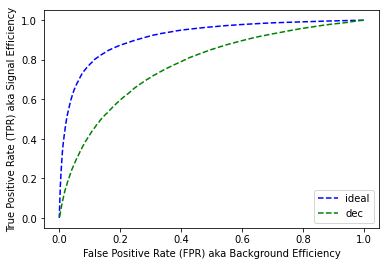

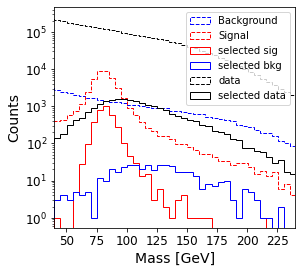

In [8]:
sign=-1
y_torch_test_v2=y_torch_test
oot=sign*outputs_optimal_test.detach().numpy().flatten()
ootd=sign*(outputs_optimal_test_dec).detach().numpy().flatten()
roc_ideal_full     = compute_ROC(y_torch_test_v2.detach().numpy().flatten(),oot)
roc_ideal_fulldec  = compute_ROC(y_torch_test_v2.detach().numpy().flatten(),ootd)
#roc_curve(y_score=outputs_optimal_test,     y_true=y_torch_test)
#roc_curve(y_score=outputs_optimal_test_dec, y_true=y_torch_test)

plt.plot(roc_ideal_full[0],    roc_ideal_full[1],'b--',label="ideal")
plt.plot(roc_ideal_fulldec[0], roc_ideal_fulldec[1],'g--',label="dec")

plt.xlabel("False Positive Rate (FPR) aka Background Efficiency")
plt.ylabel("True Positive Rate (TPR) aka Signal Efficiency")
plt.legend(loc="lower right")
plt.show()

outputs_test_dec = simple_model3_dec(x_torch_test)
scores=(outputs_test_dec).detach().numpy().flatten()
lLabels=y_torch_test.detach().numpy().flatten()
lMass=m_torch_test.detach().numpy().flatten()
cut = find_threshold(sign*scores,(lLabels == 0),0.99)
bins, fig, ax = plot_hists(cut,sign*scores,test_mass=lMass,test_labels=lLabels,c="royalblue",density=False)

data_outputs         = simple_model3_dec(torch.from_numpy(data_samples))
data_scores=(data_outputs[:,0]).detach().numpy().flatten()
_,bins,_=ax.hist(data_mass, histtype="step",color="k",bins=bins,range=(40,240),density=False,ls="--", label="data")
_,bins,_=ax.hist(data_mass[sign*data_scores>cut], histtype="step",color="k",bins=bins,range=(40,240),density=False, label="selected data")
plt.legend()
plt.show()


In [ ]:
nspace=4
x_torch,y_torch,m_torch,x_torch_test,y_torch_test,m_torch_test  = makeTorchData(dataset,labels,contrast=True,iFactor=0.5)
y_torch=1-y_torch
simple_model4    = simple_MLP(input_size=(nspace),act_out=False,nhidden=16,batchnorm=False)
#cor2_criterion = CorrLoss2()

simple_CTR       = simple_MLP(out_channels=nspace,act_out=False,batchnorm=False)
simple_model     = simple_MLP(input_size=nspace,act_out=False,nhidden=64)
mass_model       = simple_MLP(input_size=1)
simple_criterion = torch.nn.BCELoss()
mse_criterion    = nn.MSELoss()
clr_criterion    = VICRegLoss(lambda_param=1.0,mu_param=1.0,nu_param=1.0)
#clr_criterion   = BarlowTwinsLoss(lambda_param=1.0)
#clr_criterion  = SupConLoss()
cor_criterion  = CorrLoss(ipow=1) #CorrLoss2
acr_criterion  = CorrLoss(corr=True)
cor2_criterion = CorrLoss2()

train(mass_model,m_torch,y_torch)
with torch.no_grad():
    mlearn = mass_model(m_torch)

#Below is with dual training
totalparams = list(simple_CTR.parameters()) + list(simple_model4.parameters())
#Turning off dual training
#totalparams = list(simple_CTR.parameters())
simple_optimizer = torch.optim.Adam(totalparams, lr=0.001) 
npos  = len(y_torch[y_torch==0]); nneg = len(y_torch)-npos

batch=5000
for epoch in range(501):
    randpos1=torch.randperm(npos)[0:batch]; randneg1=npos+torch.randperm(nneg)[0:batch]
    randpos2=torch.randperm(npos)[0:batch]; randneg2=npos+torch.randperm(nneg)[0:batch]
    r1=torch.cat((randpos1,randneg1))
    r2=torch.cat((randpos2,randneg2))
    x_train1=x_torch[r1]#[0:batch]]
    x_train2=x_torch[r2]#[0:batch]]
    m_train1=m_torch[r1]#[0:batch]]
    m_train2=m_torch[r2]
    y_tmp1 = y_torch[r1]
    y_tmp2 = y_torch[r2]
    simple_optimizer.zero_grad()
    outputs1     = simple_CTR(x_train1)
    outputs2     = simple_CTR(x_train2)
    loss_clr,loss_corr,loss_var     = clr_criterion(outputs1,outputs2)
    #loss_clr     = 100*clr_criterion(outputs1,outputs2)
    loss_corr1   = (cor_criterion(outputs1[:,0:1],m_train1,y_tmp1==1)+cor_criterion(outputs2[:,0:1],m_train2,y_tmp2==1))
    loss_corr2   = (acr_criterion(outputs1[:,(nspace-1):nspace],m_train1)+acr_criterion(outputs2[:,(nspace-1):nspace],m_train2))    
    #loss_corr    = clr_criterion1(outputs1,outputs2)
    outputs11    = simple_model4(outputs1[:,0:(nspace)])
    outputs12    = simple_model4(outputs2[:,0:(nspace)])
    loss_bce     = 0.5*(mse_criterion(outputs11,y_tmp1)+mse_criterion(outputs12,y_tmp2))
    loss_mlcorr  = 0.5*(cor_criterion(outputs11,m_train1,y_tmp1==1)+cor_criterion(outputs12,m_train2,y_tmp2==1))    
    #loss = loss_clr+0.001*(loss_corr1+loss_corr2)#+loss_bce
    #loss = loss_clr+loss_corr+loss_var+0.001*(loss_corr1+loss_mlcorr+loss_corr2)+10*loss_bce
    loss = loss_clr+loss_corr*10+loss_var+0.001*(loss_corr1+loss_corr2+loss_mlcorr)+10*loss_bce
    loss.backward()
    simple_optimizer.step()   
    current_loss = loss.item()
    clr_loss     = loss_clr.item()#+loss_corr1.item()+loss_corr2.item()
    corr_loss    = loss_corr1.item()
    var_loss     = loss_var.item()
    corr1_loss   = loss_bce.item()
    corr2_loss   = loss_corr2.item()#loss_mlcorr.item()
    if epoch % 100 == 0: print('[%d] loss: %.4f %.4f %.4f %.4f %.4f %.4f' % (epoch + 1,  current_loss,clr_loss,corr_loss,var_loss,corr1_loss,corr2_loss))
    

r=torch.randperm(len(y_torch))
x_torch=x_torch[r]
y_torch=y_torch[r]
m_torch=m_torch[r]
with torch.no_grad():
    outputs_optimal_clr_bar = simple_CTR(x_torch)
simple_optimizer = torch.optim.Adam(simple_model.parameters(), lr=0.001) 
for epoch in range(501):
    simple_optimizer.zero_grad()
    outputs  = simple_model(outputs_optimal_clr_bar)
    loss     = mse_criterion(outputs, y_torch)
    loss.backward()
    simple_optimizer.step()    
    # add loss statistics
    current_loss = loss.item()
    if epoch % 50 == 0: print('[%d] loss: %.4f  ' % (epoch + 1,  current_loss))

'''
r=torch.randperm(len(y_torch))
x_torch=x_torch[r]
y_torch=y_torch[r]
m_torch=m_torch[r]
with torch.no_grad():
    outputs_optimal_clr_bar_dec = (simple_CTR(x_torch))[:,0:(nspace)]
simple_optimizer = torch.optim.Adam(simple_model4.parameters(), lr=0.001) 
for epoch in range(501):
    simple_optimizer.zero_grad()
    outputs   = simple_model4(outputs_optimal_clr_bar_dec)
    loss_bce  = mse_criterion(outputs, y_torch)
    loss_corr = cor_criterion(outputs,m_torch,y_torch==1)    
    loss = loss_bce+100000*loss_corr
    loss.backward()
    simple_optimizer.step()    
    # add loss statistics
    current_loss = loss.item()
    bce_loss     = loss_bce.item()
    corr_loss    = loss_corr.item()
    if epoch % 50 == 0: print('[%d] loss: %.4f %.4f %.4f ' % (epoch + 1,  current_loss,bce_loss,corr_loss))
    
'''

loss: 0.7362461090087891
[1] loss: 7.4553 0.0000 2200.3557 0.9895 0.2867 472.0388


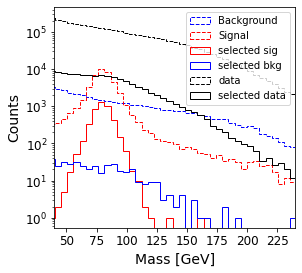

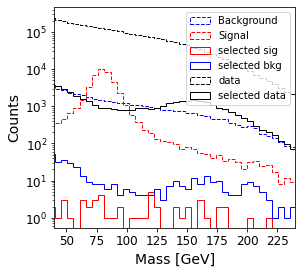

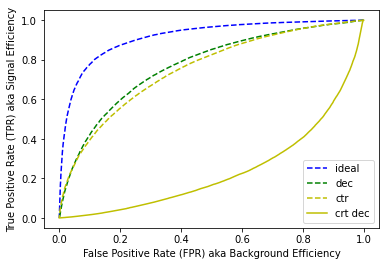

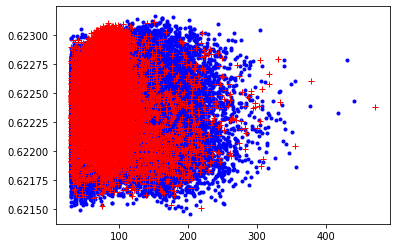

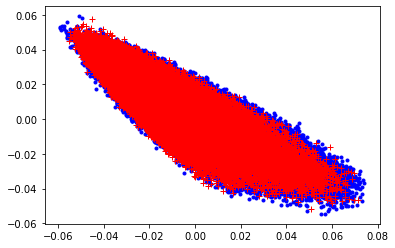

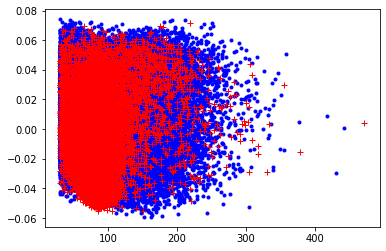

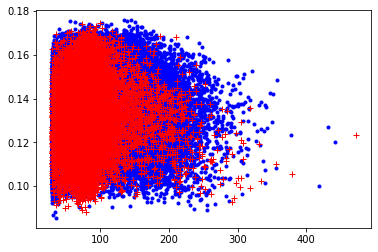

IndexError: boolean index did not match indexed array along dimension 0; dimension is 3151134 but corresponding boolean dimension is 3151128

In [15]:
with torch.no_grad():
    outputs_test_clr_bar    = simple_CTR(x_torch_test)
    outputs_test_clr_bar_X  = torch.sigmoid(simple_model(outputs_test_clr_bar))
    #outputs_test_clr_bar_dec = simple_model4(outputs_test_clr_bar[:,0:(nspace)])
    outputs_test_clr_bar_dec = torch.sigmoid(simple_model4(outputs_test_clr_bar[:,0:(nspace)]))
    data_outputs         = simple_CTR(torch.from_numpy(data_samples))
    #data_outputs_dec     = simple_model4(data_outputs[:,0:(nspace)])
    data_mass_clean      = data_mass[~torch.any(data_outputs.isnan(),dim=1)]
    data_outputs         = data_outputs[~torch.any(data_outputs.isnan(),dim=1)]
    data_outputs_dec     = torch.sigmoid(simple_model4(data_outputs[:,0:(nspace)]))
    data_outputs_X       = torch.sigmoid(simple_model(data_outputs[:,0:(nspace)]))
    
sign=-1
scores=(sign*outputs_test_clr_bar_X[:,0]).detach().numpy().flatten()
data_scores=(sign*data_outputs_X[:,0]).detach().numpy().flatten()

scores_dec=(sign*outputs_test_clr_bar_dec[:,0]).detach().numpy().flatten()
data_scores_dec=(sign*data_outputs_dec[:,0]).detach().numpy().flatten()

lLabels=y_torch_test.detach().numpy().flatten()
lMass=m_torch_test.detach().numpy().flatten()
cut = find_threshold(scores,(lLabels == 0),0.99)
bins, fig, ax = plot_hists(cut,scores,test_mass=lMass,test_labels=lLabels,c="dodgerblue",density=False)
_,bins,_=ax.hist(data_mass_clean, histtype="step",color="k",bins=bins,range=(40,240),density=False,ls="--", label="data")
_,bins,_=ax.hist(data_mass_clean[data_scores>cut], histtype="step",color="k",bins=bins,range=(40,240),density=False, label="selected data")
plt.legend()
plt.show()

cut_dec = find_threshold(scores_dec,(lLabels == 0),0.99)
bins, fig, ax = plot_hists(cut_dec,scores_dec,test_mass=lMass,test_labels=lLabels,c="dodgerblue",density=False)
_,bins,_=ax.hist(data_mass_clean, histtype="step",color="k",bins=bins,range=(40,240),density=False,ls="--", label="data")
_,bins,_=ax.hist(data_mass_clean[data_scores_dec>cut_dec], histtype="step",color="k",bins=bins,range=(40,240),density=False, label="selected data")
plt.legend()
plt.show()

#plt.hist(outputs_test_bar[y_torch_test.flatten() == 0].detach().numpy().flatten(),alpha=0.5)
#plt.hist(outputs_test_bar[y_torch_test.flatten() == 1].detach().numpy().flatten(),alpha=0.5)
#plt.show()

roc_ideal_ctrdec      = compute_ROC(y_torch_test.detach().numpy().flatten(),sign*outputs_test_clr_bar_dec[:,0].detach().numpy().flatten())
roc_ideal_fullctr     = compute_ROC(y_torch_test.detach().numpy().flatten(),sign*outputs_test_clr_bar_X.detach().numpy().flatten())

plt.plot(roc_ideal_full[0],    roc_ideal_full[1],'b--',label="ideal")
plt.plot(roc_ideal_fulldec[0], roc_ideal_fulldec[1],'g--',label="dec")
plt.plot(roc_ideal_fullctr[0], roc_ideal_fullctr[1],'y--',label="ctr")
plt.plot(roc_ideal_ctrdec[0],  roc_ideal_ctrdec[1],'y-',label="crt dec")

plt.xlabel("False Positive Rate (FPR) aka Background Efficiency")
plt.ylabel("True Positive Rate (TPR) aka Signal Efficiency")
plt.legend(loc="lower right")
plt.show()


#This plot should be correlated
plt.plot(m_torch_test[y_torch_test.flatten() == 0],outputs_test_clr_bar_dec[y_torch_test.flatten() == 0][:,0].detach().numpy(), 'k.',c='b')
plt.plot(m_torch_test[y_torch_test.flatten()  > 0],outputs_test_clr_bar_dec[y_torch_test.flatten() > 0][:,0].detach().numpy(), 'k+',c='r')
plt.show()

with torch.no_grad():
    test_optimal_clr_bar = simple_CTR(x_torch_test)

#This is the output space split by type
plt.plot(test_optimal_clr_bar[y_torch_test.flatten() == 0][:,0].detach().numpy(),test_optimal_clr_bar[y_torch_test.flatten() == 0][:,1].detach().numpy(), 'k.',c='b')
plt.plot(test_optimal_clr_bar[y_torch_test.flatten() == 1][:,0].detach().numpy(),test_optimal_clr_bar[y_torch_test.flatten() == 1][:,1].detach().numpy(), 'k+',c='r')
plt.show()

#This plot should NOT be correlated
plt.plot(m_torch_test[y_torch_test.flatten() == 0],test_optimal_clr_bar[y_torch_test.flatten() == 0][:,0].detach().numpy(), 'k.',c='b')
plt.plot(m_torch_test[y_torch_test.flatten()  > 0],test_optimal_clr_bar[y_torch_test.flatten()  > 0][:,0].detach().numpy(), 'k+',c='r')
plt.show()

#This plot should be correlated
plt.plot(m_torch_test[y_torch_test.flatten() == 0],test_optimal_clr_bar[y_torch_test.flatten() == 0][:,nspace-1].detach().numpy(), 'k.',c='b')
plt.plot(m_torch_test[y_torch_test.flatten()  > 0],test_optimal_clr_bar[y_torch_test.flatten() > 0][:,nspace-1].detach().numpy(), 'k+',c='r')
plt.show()

_,bins,_=ax.hist(data_mass[data_scores>cut], histtype="step",color="k",bins=bins,range=(40,240),density=False, label="selected data")
plt.show()

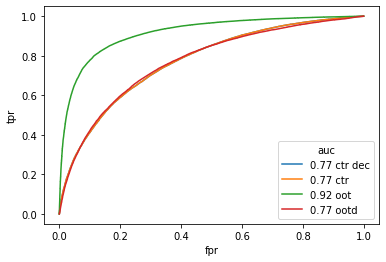

In [11]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

def plotAUC(iscores,ilabels):
    auc = roc_auc_score(y_score=iscores, y_true=ilabels.detach().numpy().flatten())
    fpr, tpr, cuts = roc_curve(y_score=iscores, y_true=ilabels)
    #fig, ax = plt.subplots(1,1,figsize=(4,3),dpi=150)
    return fpr,tpr,auc

fpr1,tpr1,auc1=plotAUC(scores,y_torch_test)
fpr2,tpr2,auc2=plotAUC(sign*outputs_test_clr_bar_X,y_torch_test)
fpr3,tpr3,auc3=plotAUC(oot,y_torch_test_v2)
fpr4,tpr4,auc4=plotAUC(ootd,y_torch_test_v2)
plt.plot(fpr1, tpr1,label=f"{auc1:.2f}"+" ctr dec")
plt.plot(fpr2, tpr2,label=f"{auc2:.2f}"+" ctr")
plt.plot(fpr3, tpr3,label=f"{auc3:.2f}"+" oot")
plt.plot(fpr4, tpr4,label=f"{auc4:.2f}"+" ootd")
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.legend(title="auc")

In [ ]:
#plotting code to plot everything
#From https://github.com/MIT-8s50/course/blob/main/Project2/extra/DNN-Wtag_key.ipynb

def selection(iData):
    """
    We will want the neural network to do most of the work here so this selection should be as simple as possible. Returns a boolean array
    for the events passing the selection.

    Parameters
    ----------
    iData : uproot.models.TTree.Model_TTree_v19
        Root TTree containing the events of interest.
        
    returns allcuts (type=Array) 
    """
    #lets apply a trigger selection
    trigger = (iData.arrays('trigger', library="np")["trigger"].flatten() > 0)
    #Now lets require the jet pt to be above a threshold
    jetpt = (iData.arrays('vjet0_pt', library="np")["vjet0_pt"].flatten() > 400)
    #Lets apply both jetpt and trigger at the same time
    #standard_trig = (iData.arrays('trigger', library="np")["trigger"].flatten() % 4 > 1) #lets require one of our standard triggers (jet pT > 370 )
    allcuts = np.logical_and.reduce([trigger, jetpt])
    return allcuts

def integral(iData, iWeights):
    #perform a selection on the data
    mask_sel = selection(iData)
    #now iterate over the weights note the weights are in the format of [number,variable name 1, variable name 2,...]
    weight = iWeights[0]
    for i0 in range(1, len(iWeights)):
        weightarr = iData.arrays(
            iWeights[i0], library="np")[iWeights[i0]][mask_sel].flatten()
        #multiply the weights
        weight = weight * weightarr
    #now take the integral and return it
    return np.sum(weight)


def scale(iData8TeV, iData13TeV, iWeights):
    int_8TeV = integral(iData8TeV, iWeights)
    int_13TeV = integral(iData13TeV, iWeights)
    S = int_8TeV / int_13TeV
    print("Scale:", S, int_8TeV, int_13TeV)
    return S

def get_weights(weights, iData, sel):
    weight = weights[0]
    for i in range(1, len(weights)):
        weight *= iData.arrays(weights[i], library="np")[weights[i]][sel]
    return weight


# get scores
with torch.no_grad():
    module0.eval()
    qcd_scores = torch.sigmoid(module0(torch.from_numpy(qcd_samples))).numpy().flatten()
    w_scores = torch.sigmoid(module0(torch.from_numpy(w_samples))).numpy().flatten()
    data_scores = torch.sigmoid(module0(torch.from_numpy(data_samples))).numpy().flatten()
    z_scores = torch.sigmoid(module0(torch.from_numpy(z_samples))).numpy().flatten()
    zz_scores = torch.sigmoid(module0(torch.from_numpy(zz_samples))).numpy().flatten()
    wz_scores = torch.sigmoid(module0(torch.from_numpy(wz_samples))).numpy().flatten()
    ww_scores = torch.sigmoid(module0(torch.from_numpy(ww_samples))).numpy().flatten()
    tt_scores = torch.sigmoid(module0(torch.from_numpy(tt_samples))).numpy().flatten()
    ggh_scores = torch.sigmoid(module0(torch.from_numpy(ggh_samples))).numpy().flatten()

In [ ]:
#Lets Look at the mass
weights=[1000*18300,"puweight","scale1fb"]
density = True
mrange, bins = (30,200), 60
#cut = .44
cut = .45

wscale=scale(wqq,wqq13,weights)
zscale=scale(zqq,zqq13,weights)


# qcd_mask = np.zeros(len(data))
# qcd_mask[np.array(valdataset.indices)[(scores<cut)&(all_labels==1)]] = 1
# w_mask = np.zeros(len(data))
# w_mask[np.array(valdataset.indices)[(scores<cut)&(all_labels==0)]] = 1
qcd_mask = (qcd_scores<cut)
w_mask = (w_scores<cut)
z_mask = (z_scores<cut)
data_mask = (data_scores<cut)
ww_mask = (ww_scores<cut)
wz_mask = (wz_scores<cut)
zz_mask = (zz_scores<cut)
tt_mask = (tt_scores<cut)
ggh_mask = (ggh_scores<cut)

hist_weights = [get_weights(weights,qcd,qcdsel)[qcd_mask],
                get_weights(weights,wqq13,wsel)[w_mask]*wscale,
                get_weights(weights,zqq13,zsel)[z_mask]*zscale,
                get_weights(weights,tt,ttsel)[tt_mask],
                get_weights(weights,ggh,gghsel)[ggh_mask],
                get_weights(weights,zz,zzsel)[zz_mask],
                get_weights(weights,wz,wzsel)[wz_mask],
                get_weights(weights,ww,wwsel)[ww_mask],
               ]
hists = [qcd_mass[qcd_mask],
         w_mass[w_mask],
         z_mass[z_mask],
         tt_mass[tt_mask],
         ggh_mass[ggh_mask],
         zz_mass[zz_mask],
         wz_mass[wz_mask],
         ww_mass[ww_mask],
        ]
plot_labels = ["QCD", "W", "Z", "tt", "ggh", "zz", "wz", "ww"]
plot_colors = ["royalblue",'r',"orange", "cyan", "purple", "brown", "green", "crimson"]
# plt.hist(all_mass[(scores<cut)&(all_labels==0)], bins=bins, range=mrange, alpha=0.6, label="W")
# plt.hist(all_mass[(scores<cut)&(all_labels==1)], bins=bins, range=mrange, alpha=0.6, label="QCD")
fig, ax = plt.subplots(1,1,figsize=(8,6),dpi=150)
_,bins,_ = plt.hist(hists,
         color=plot_colors, label=plot_labels, weights=hist_weights,
         range=mrange, bins=bins, alpha=.6, density=density,stacked=True)
counts, _ = np.histogram(data_mass[data_mask],bins=bins,density=density)
yerr = np.sqrt(counts) 
if density: yerr /= np.sqrt(sum(data_mask)*(bins[1]-bins[0]))
binCenters = (bins[1:]+bins[:-1])*.5
plt.errorbar(binCenters, counts, yerr=yerr,fmt="o",c="k",label="data", ms=3)
# plt.hist(datat21, range=mrange,
#          bins=50, color='k',label="data", alpha=.6, density=density)
# plt.hist(wt21, weights=get_weights(wqq13,weights,wsel)*wscale, range=mrange,
#          bins=50, color='red',label="W", alpha=.6, density=density)
# plt.hist(zt21, weights=get_weights(zqq13,weights,zsel)*zscale, range=mrange,
#          bins=50, color='blue',label="Z", alpha=.6, density=density)
# plt.hist(ht21, weights=get_weights(ggh,weights,hsel),
#          bins=50, color='black',label="H", alpha=.6, density=True)
plt.ylim(0,0.015)
plt.legend()
plt.xlabel(r"Mass [GeV]")
plt.ylabel("Normalized Counts")
plt.show()